In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten

# Load data
historical_weather = pd.read_csv('historical_weather.csv')
submission_key = pd.read_csv('submission_key.csv')

# Handle missing values
historical_weather.fillna(method='ffill', inplace=True)
historical_weather.fillna(method='bfill', inplace=True)

# Feature engineering: Extract year, month, day from date
historical_weather['date'] = pd.to_datetime(historical_weather['date'])
historical_weather['year'] = historical_weather['date'].dt.year
historical_weather['month'] = historical_weather['date'].dt.month
historical_weather['day'] = historical_weather['date'].dt.day

# Normalizing the data
scaler = StandardScaler()
historical_weather[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh']] = scaler.fit_transform(historical_weather[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh']])

# Prepare the data for the model
features = ['city_id', 'year', 'month', 'day', 'min_temp_c', 'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh']
X = historical_weather[features]
y = historical_weather['avg_temp_c']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert city_id to categorical
X_train = pd.get_dummies(X_train, columns=['city_id'])
X_val = pd.get_dummies(X_val, columns=['city_id'])


In [37]:
historical_weather.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,year,month,day
0,C001,2014-01-01,-1.272181,-1.615209,-1.190756,-0.31199,0.196174,-0.067019,-0.799181,2014,1,1
1,C001,2014-01-02,-0.998956,-0.843573,-1.026430,-0.31199,0.196174,-0.189693,-0.187023,2014,1,2
2,C001,2014-01-03,-1.170986,-1.284508,-0.958766,-0.31199,0.196174,-0.189693,-0.863619,2014,1,3
3,C001,2014-01-04,-1.170986,-1.084083,-1.026430,-0.31199,0.196174,1.093667,0.022399,2014,1,4
4,C001,2014-01-05,-1.069792,-1.424805,-0.678445,-0.31199,0.196174,1.093667,-0.992494,2014,1,5


In [16]:
#set random seed
tf.random.set_seed(42)

# create model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mse"])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
4559/4559 [==============================] - 8s 2ms/step - loss: 25.1241 - mse: 25.1241 - val_loss: 1.0244 - val_mse: 1.0244
Epoch 2/50
4559/4559 [==============================] - 7s 2ms/step - loss: 1.0515 - mse: 1.0515 - val_loss: 1.0078 - val_mse: 1.0078
Epoch 3/50
4559/4559 [==============================] - 7s 2ms/step - loss: 1.0000 - mse: 1.0000 - val_loss: 1.0084 - val_mse: 1.0084
Epoch 4/50
4559/4559 [==============================] - 7s 2ms/step - loss: 0.9995 - mse: 0.9995 - val_loss: 1.0080 - val_mse: 1.0080
Epoch 5/50
4559/4559 [==============================] - 7s 2ms/step - loss: 1.0005 - mse: 1.0005 - val_loss: 1.0079 - val_mse: 1.0079
Epoch 6/50
4559/4559 [==============================] - 8s 2ms/step - loss: 0.9985 - mse: 0.9985 - val_loss: 1.0078 - val_mse: 1.0078
Epoch 7/50
4559/4559 [==============================] - 7s 2ms/step - loss: 0.9983 - mse: 0.9983 - val_loss: 1.0078 - val_mse: 1.0078
Epoch 8/50
4559/4559 [==============================] - 7s 2

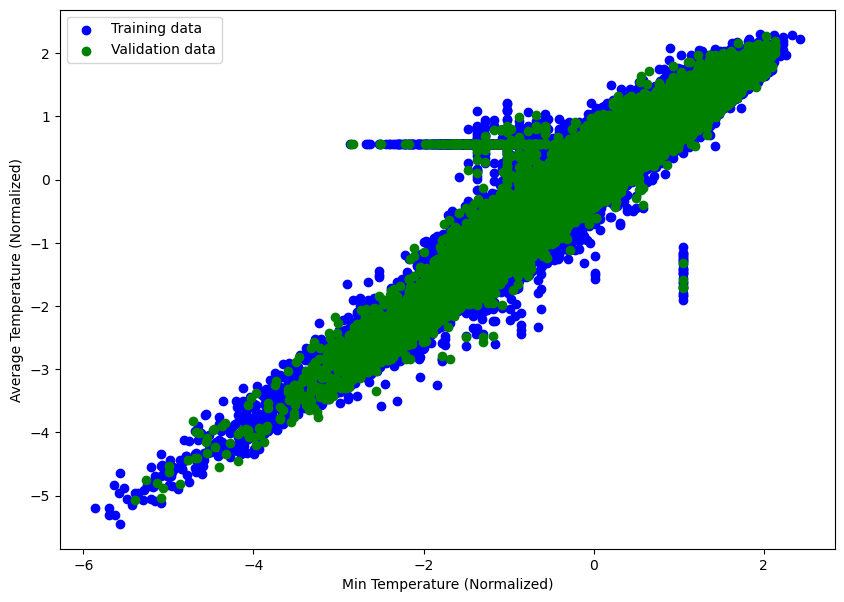

In [17]:

# Ensure consistent sizes for plotting
X_train_sample = X_train.iloc[:, 3].values  # Example: use the 4th feature (min_temp_c)
X_val_sample = X_val.iloc[:, 3].values

# Plotting the training and validation data
plt.figure(figsize=(10, 7))
plt.scatter(X_train_sample, y_train, c='b', label='Training data')
plt.scatter(X_val_sample, y_val, c='g', label='Validation data')
plt.xlabel('Min Temperature (Normalized)')
plt.ylabel('Average Temperature (Normalized)')
plt.legend()
plt.show()

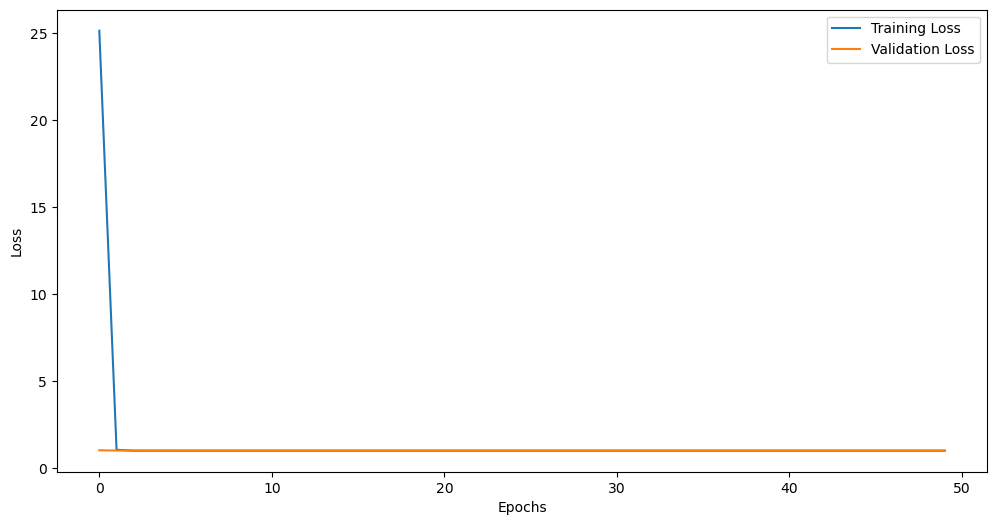

In [18]:
# Plotting the learning curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
val_predictions = model.predict(X_val).flatten()  # Flatten the predictions to make them 1D
rmse = np.sqrt(np.mean((val_predictions - y_val) ** 2))
print(f'Validation RMSE: {rmse}')

1140/1140 [==============================] - 1s 795us/step
Validation RMSE: 1.0039547130128708


In [36]:
# Prepare the test data (first week of 2019)
test_data = submission_key.copy()
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month
test_data['day'] = test_data['date'].dt.day

test_data = test_data.merge(historical_weather, on=['city_id', 'year', 'month', 'day'], how='left')
test_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='bfill', inplace=True)

X_test = test_data[features]
X_test = pd.get_dummies(X_test, columns=['city_id'])

# Predict
predictions = model.predict(X_test)

# Create submission file
submission = pd.DataFrame({'submission_ID': submission_key['submission_ID'], 'avg_temp_c': predictions.flatten()})
submission.to_csv('submission.csv', index=False)

22/22 [==============================] - 0s 952us/step
